# CS 109A/AC 209A/STAT 121A Data Science: Data Driven March Madness Milestone #3
**Harvard University**<br>
**Fall 2016**<br>
**Instructors: W. Pan, P. Protopapas, K. Rader**<br>
**Due Date: ** Saturday, November 6th, 2016 at 11:59pm

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import random
import copy
from mpl_toolkits.mplot3d import Axes3D
import csv
from sklearn import linear_model
import sklearn.discriminant_analysis as da
%matplotlib inline

**Loading in Each Dataframe:**

In [2]:
teams_df = pd.read_csv('datasets/Teams.csv', delimiter=',')
seasons_df = pd.read_csv('datasets/Seasons.csv', delimiter = ',')
seasons_results_detailed_df = pd.read_csv('datasets/RegularSeasonDetailedResults.csv', delimiter = ',')
seasons_results_compact_df = pd.read_csv('datasets/RegularSeasonCompactResults.csv', delimiter = ',')
tourney_results_detailed_df = pd.read_csv('datasets/TourneyDetailedResults.csv', delimiter = ',')
tourney_results_compact_df = pd.read_csv('datasets/TourneyCompactResults.csv', delimiter = ',')
tourney_seeds_df = pd.read_csv('datasets/TourneySeeds.csv', delimiter = ',')

**Creating Additional Datasets:**

In [3]:
# def add_to_csv(df_lst, m = 'a'):
#     #write pandas to csv
#     count = 2003
#     if m == 'a':
#         for df in df_lst:
#             #create csv and add pandas, use name
#             df.to_csv('datasets/toruney_selected_reg_season_detailed_results/reg_season/%s_regular_seas.csv'%count)
#             count += 1
#     else:
#         for df in df_lst:
#             #create csv and add pandas, use name
#             df.to_csv('datasets/toruney_selected_reg_season_detailed_results/tourney/%s_tourney.csv'%count)
#             count += 1

# #create a dictionary to store which teams were in which years
# yearly_dfs = []
# teams_per_year = {}
# for i in range(2003, 2016, 1):
#     teams_per_year[i] = []

# for key, value in teams_per_year.iteritems():
#     year = tourney_results_detailed_df[tourney_results_detailed_df.Season == key]
#     wteam_array = year['Wteam']
#     team_array = np.append(wteam_array, year['Lteam'])
#     teams_per_year[key] = sorted(np.unique(team_array))

# for key, value in teams_per_year.iteritems():
#     _yearly_df = pd.DataFrame(columns = list(seasons_results_detailed_df.columns.values))
#     for index, row in seasons_results_detailed_df[seasons_results_detailed_df.Season == key].iterrows():
#         if row['Wteam'] in value or row['Lteam'] in value:
#             _yearly_df = _yearly_df.append(row)
#     yearly_dfs.append(_yearly_df)
    
# tourney_dfs = []
# for i in range(2003, 2016, 1):
#     tourney_dfs.append(tourney_results_detailed_df[tourney_results_detailed_df.Season == i])
    
# add_to_csv(tourney_dfs, m = 'd')
# add_to_csv(yearly_dfs)

**Preliminary Model Setup:**

In [4]:
### Assemble season long stats for each team in each year
leagueData = {}
categories = ['pointDifferential', 'fieldGoalsMade', 'fieldGoalsAtt', 'freeThrowsMade',
                  'freeThrowAtt', 'offReb', 'assists', 'turnovers', 'defReb', 'steals', 
                 'blocks', 'fieldGoalsAllowed', 'oppFieldGoalsAtt', 'freeThrowsAllowed', 
                 'oppFreeThrowsAtt']

for index, game in seasons_results_detailed_df.iterrows():
    year = int(game['Season'])
    winningTeam = int(game['Wteam'])
    losingTeam = int(game['Lteam'])
    
    winningTeamStats = {}
    losingTeamStats = {}
    
    pointDifferential = int(game['Wscore']) - int(game['Lscore'])
    winningTeamStats['pointDifferential'] = pointDifferential
    losingTeamStats['pointDifferential'] = pointDifferential * -1
    
    winningTeamStats['fieldGoalsMade'] = int(game['Wfgm'])
    losingTeamStats['fieldGoalsMade'] = int(game['Lfgm'])
    
    winningTeamStats['fieldGoalsAtt'] = int(game['Wfga'])
    losingTeamStats['fieldGoalsAtt'] = int(game['Lfga'])
    
    winningTeamStats['freeThrowsMade'] = int(game['Wftm'])
    losingTeamStats['freeThrowsMade'] = int(game['Lftm'])
    
    winningTeamStats['freeThrowAtt'] = int(game['Wfta'])
    losingTeamStats['freeThrowAtt'] = int(game['Lfta'])
    
    winningTeamStats['offReb'] = int(game['Wor'])
    losingTeamStats['offReb'] = int(game['Lor'])
    
    winningTeamStats['assists'] = int(game['Wast'])
    losingTeamStats['assists'] = int(game['Last'])
    
    winningTeamStats['turnovers'] = int(game['Wto'])
    losingTeamStats['turnovers'] = int(game['Lto'])
    
    winningTeamStats['defReb'] = int(game['Wdr'])
    losingTeamStats['defReb'] = int(game['Ldr'])
    
    winningTeamStats['steals'] = int(game['Wstl'])
    losingTeamStats['steals'] = int(game['Lstl'])
    
    winningTeamStats['blocks'] = int(game['Wblk'])
    losingTeamStats['blocks'] = int(game['Lblk'])  

    winningTeamStats['fieldGoalsAllowed'] = int(game['Lfgm'])
    losingTeamStats['fieldGoalsAllowed'] = int(game['Wfgm'])
    
    winningTeamStats['oppFieldGoalsAtt'] = int(game['Lfga'])
    losingTeamStats['oppFieldGoalsAtt'] = int(game['Wfga'])
    
    winningTeamStats['freeThrowsAllowed'] = int(game['Lftm'])
    losingTeamStats['freeThrowsAllowed'] = int(game['Wftm'])
    
    winningTeamStats['oppFreeThrowsAtt'] = int(game['Lfta'])
    losingTeamStats['oppFreeThrowsAtt'] = int(game['Wfta'])
    
    if year not in leagueData:
        leagueData[year] = {}

    if winningTeam in leagueData[year]:
        for category in categories:
            leagueData[year][winningTeam][category] += winningTeamStats[category]
        leagueData[year][winningTeam]['totalGames'] += 1
    else:
        leagueData[year][winningTeam] = winningTeamStats
        leagueData[year][winningTeam]['totalGames'] = 1
        
    if losingTeam in leagueData[year]:
        for category in categories:
            leagueData[year][losingTeam][category] += winningTeamStats[category]
        leagueData[year][losingTeam]['totalGames'] += 1
    else:
        leagueData[year][losingTeam] = losingTeamStats
        leagueData[year][losingTeam]['totalGames'] = 1

for year in leagueData:
    for team in leagueData[year]:
        totalTeamGames = leagueData[year][team]['totalGames']

        for category in leagueData[year][team]:
            leagueData[year][team][category] = leagueData[year][team][category]/float(totalTeamGames)

In [5]:
class MarchMadnessTournament:
    def __init__(self, year):
        self.year = year
        self.tourney_df = pd.read_csv('datasets/toruney_selected_reg_season_detailed_results/tourney/' + str(year) + '_tourney.csv', delimiter = ',')
        self.matchups = self.bracket_matchups(self.tourney_df)
        self.actualBracket = self.actual_bracket(self.tourney_df)
        self.teamToSeedMapping = self.create_team_to_seed_mapping(self.year)
        self.baselineBracket = self.lower_seed_bracket(self.tourney_df, self.year, self.matchups, self.teamToSeedMapping)
        self.modelBracket = None
        self.topBrackets = None
        
        self.baselineMatchupAccuracy = self.baseline_matchup_accuracy(self.tourney_df, self.year, self.teamToSeedMapping)
        self.modelMatchupAccuracy = None
        
        self.trainAndTestModel(self.year, 'single')
        self.trainAndTestModel(self.year, 'top20')

        self.baselineBracketAccuracy = self.weighted_accuracy(self.actualBracket, self.baselineBracket)
        self.modelBracketAccuracy = self.weighted_accuracy(self.actualBracket, self.modelBracket)
        self.modelBracketVariance = self.differential_score(self.baselineBracket, self.modelBracket)
        
    # Given: all the matchups in a tournament
    # Return: a list of lists of lists representing the matchups in each round
    def bracket_matchups(self, tourney_df):
        rounds = [[], [], [], [], [], []]
        count = 0
        temp = [] # keeps track of which teams have already been seen in the previous round

        for index, row in tourney_df.iterrows():
            if row['Wteam'] in temp:
                count += 1
                temp = []
            rounds[count].append([row['Wteam'], row['Lteam']])
            temp.append(row['Wteam'])
            temp.append(row['Lteam'])

        return rounds
    
    # Given: all the matchups in a tournament
    # Return: a list of lists representing all the winners in each round
    def actual_bracket(self, tourney_df):
        rounds = [[], [], [], [], [], []]
        temp = []
        count = 0

        for index, row in tourney_df.iterrows():
            if row['Wteam'] in temp:
                count += 1
                temp = []
            rounds[count].append(row['Wteam'])
            temp.append(row['Wteam'])

        return rounds
    
    def create_team_to_seed_mapping(self, tournamentYear):
        teamToSeedMapping = {}
        for year in range(tournamentYear-3, tournamentYear+1):
            seedsForYear = {}
            seeds = tourney_seeds_df[tourney_seeds_df.Season == year]
            for index, row in seeds.iterrows():
                try:
                    seedsForYear[int(row['Team'])] = int(row['Seed'][1:])
                except:
                    seedsForYear[int(row['Team'])] = int(row['Seed'][1:-1])

            teamToSeedMapping[year] = seedsForYear
        
        return teamToSeedMapping
    
    # Parameters: All the matchups and the year of a tournament
    # Return: A list of lists representing a bracket that a baseline model would predict (lower seed always wins)
    def lower_seed_bracket(self, tourney_df, tournamentYear, tournamentMatchups, seedMapping):
        rounds = [[], [], [], [], [], []]
        matchups = copy.deepcopy(tournamentMatchups)
        
        for currentRound in range(6):
            for currentRoundMatchup in matchups[currentRound]:
                team1 = currentRoundMatchup[0]
                team2 = currentRoundMatchup[1]
                winningTeam = None
                losingTeam = None
                
                if seedMapping[tournamentYear][team1] > seedMapping[tournamentYear][team2]:
                    winningTeam = team2
                    losingTeam = team1
                elif seedMapping[tournamentYear][team1] < seedMapping[tournamentYear][team2]:
                    winningTeam = team1
                    losingTeam = team2
                else:
                    if random.random() < 0.5:
                        winningTeam = team1
                        losingTeam = team2
                    else:
                        winningTeam = team2
                        losingTeam = team1
                        
                rounds[currentRound].append(winningTeam)
                
                if currentRound == 5:
                    continue
                
                for matchup in matchups[currentRound+1]:
                    if losingTeam == matchup[0]:
                        matchup[0] = winningTeam
                        break
                    elif losingTeam == matchup[1]:
                        matchup[1] = winningTeam
                        break
                        
        return rounds
    
    # Given: An actual and predicted bracket (list of lists representing winners in each round)
    # Return: A weighted accuracy score
    def weighted_accuracy(self, actual, predicted):
        score = 0
        bth_pre = zip(actual, predicted)
        scalars = [1, 2, 4, 8, 16, 32]

        for index, rnd in enumerate(bth_pre):
            com = list(set(rnd[0]) & set(rnd[1]))
            score += len(com) * scalars[index]

        return score/192.0
    
    # Given: An actual and predicted bracket (list of lists representing winners in each round)
    # Return: An unweighted accuracy score
    def accuracy_score(self, actual, predicted):
        score = 0
        bth_pre = zip(actual, predicted)

        for index, rnd in enumerate(bth_pre):
            com = list(set(rnd[0]) & set(rnd[1]))
            score += len(com)

        return score/63.0
    
    # Given: Two brackets: One predicted by the baseline model, the other predicted by our model
    # Return: The variance between the two brackets
    def differential_score(self, baselineBracket, modelBracket):
        score = 0
        bth_pre = zip(baselineBracket, modelBracket)
        for rnd in bth_pre:
            com = list(set(rnd[0]) & set(rnd[1]))
            score += (len(rnd[1]) - len(com))

        return score/63.0
    
    def baseline_matchup_accuracy(self, tourney_df, tournamentYear, seedMapping):
        right = 0.0
        tot = 0.0
        for index, row in tourney_df.iterrows():
            if seedMapping[tournamentYear][row['Wteam']] < seedMapping[tournamentYear][row['Lteam']]:
                right += 1
            tot += 1
        return right/tot
    
    # Given: A Year and a Trained Logistic Regression Model (based on past 3 years of tournament data)
    def predict_bracket(self, model):
        tourney = self.tourney_df
        matchups = copy.deepcopy(self.matchups)
        actualBracket = self.actualBracket

        bracketPredictions = [[], [], [], [], [], []]
        
        for currentRound in range(6):
            for currentRoundMatchup in matchups[currentRound]:
                team1 = currentRoundMatchup[0]
                team2 = currentRoundMatchup[1]
                winningTeam = None
                losingTeam = None
                
                team1Seed = self.teamToSeedMapping[self.year][team1]
                team2Seed = self.teamToSeedMapping[self.year][team2]
                team1Stats = leagueData[self.year][team1]
                team2Stats = leagueData[self.year][team2]

                matchupVector = [team1Stats[category] + team2Stats[category] for category in categories] + [team1Seed] + [team2Seed]

                # gets the result and confidence of the result
                probEstimates = dict(zip([1,0], model.predict_proba(np.array(matchupVector).reshape(1, -1))[0]))
                result = max(probEstimates.iterkeys(), key=(lambda x: probEstimates[x]))
                confidence = probEstimates[result]

                if result == 1:
                    bracketPredictions[currentRound].append(team1)
                    winningTeam = team1
                    losingTeam = team2
                else:
                    bracketPredictions[currentRound].append(team2)
                    winningTeam = team2
                    losingTeam = team1
                        
                if currentRound == 5:
                    continue
                
                for matchup in matchups[currentRound+1]:
                    if losingTeam == matchup[0]:
                        matchup[0] = winningTeam
                        break
                    elif losingTeam == matchup[1]:
                        matchup[1] = winningTeam
                        break
                        
        self.modelBracket = bracketPredictions
    
    # Given: A Year and a Trained Logistic Regression Model (based on past 3 years of tournament data)
    def predict_brackets(self, model):
        brackets = []
        tourney = self.tourney_df
        actualBracket = self.actualBracket
        lowerSeedBracket = self.baselineBracket

        # generates 20 predicted brackets along with their weighted accuracy
        #change back to 10
        for i in range(10):
            bracketPredictions = [[], [], [], [], [], []]
            matchups = copy.deepcopy(self.matchups)
            
            for currentRound in range(6):
                for currentRoundMatchup in matchups[currentRound]:
                    team1 = currentRoundMatchup[0]
                    team2 = currentRoundMatchup[1]
                    winningTeam = None
                    losingTeam = None

                    team1Seed = self.teamToSeedMapping[self.year][team1]
                    team2Seed = self.teamToSeedMapping[self.year][team2]
                    team1Stats = leagueData[self.year][team1]
                    team2Stats = leagueData[self.year][team2]

                    matchupVector = [team1Stats[category] + team2Stats[category] for category in categories] + [team1Seed] + [team2Seed]

                    # gets the result and confidence of the result
                    probEstimates = dict(zip([1,0], model.predict_proba(np.array(matchupVector).reshape(1, -1))[0]))
                    result = max(probEstimates.iterkeys(), key=(lambda x: probEstimates[x]))
                    confidence = probEstimates[result]
                    
                    if (result == 1 and random.random() < confidence) or (result == 0 and random.random() > confidence):
                        bracketPredictions[currentRound].append(team1)
                        winningTeam = team1
                        losingTeam = team2
                    else:
                        bracketPredictions[currentRound].append(team2)
                        winningTeam = team2
                        losingTeam = team1

                    if currentRound == 5:
                        continue

                    for matchup in matchups[currentRound+1]:
                        if losingTeam == matchup[0]:
                            matchup[0] = winningTeam
                            break
                        elif losingTeam == matchup[1]:
                            matchup[1] = winningTeam
                            break
        
            brackets.append((bracketPredictions, self.weighted_accuracy(actualBracket, bracketPredictions)))

        bestWeightedBrackets = sorted(brackets, key=lambda x: x[1])

        finalRankings = []
        for bracket in bestWeightedBrackets:
            variance = self.differential_score(lowerSeedBracket, bracket[0])
            finalRankings.append((bracket[0], bracket[1], variance))

        self.topBrackets = finalRankings
    
    def trainAndTestModel(self, tournamentYear, predictionType):
        trainingData = []
        for index, game in tourney_results_detailed_df.iterrows():
            matchupVector = []
            year = int(game['Season'])

            possibleYears = range(tournamentYear-3, tournamentYear)

            if year in possibleYears:
                
                winningTeam = int(game['Wteam'])
                losingTeam = int(game['Lteam'])
                
                winningTeamSeed = self.teamToSeedMapping[year][winningTeam]
                losingTeamSeed = self.teamToSeedMapping[year][losingTeam]

                winningTeamStats = leagueData[year][winningTeam]
                losingTeamStats = leagueData[year][losingTeam]

                matchupVector = [winningTeamStats[category] + losingTeamStats[category] for category in categories] + [winningTeamSeed] + [losingTeamSeed] + [1] 
                trainingData.append(matchupVector)

                matchupVector = [losingTeamStats[category] + losingTeamStats[category] for category in categories] + [losingTeamSeed] + [winningTeamSeed] + [0]
                trainingData.append(matchupVector)

        # load testing data (the year i+3)
        testingData = []
        for index, game in tourney_results_detailed_df.iterrows():
            matchupVector = []
            year = int(game['Season'])

            if year == tournamentYear:
                winningTeam = int(game['Wteam'])
                losingTeam = int(game['Lteam'])
            
                winningTeamSeed = self.teamToSeedMapping[year][winningTeam]
                losingTeamSeed = self.teamToSeedMapping[year][losingTeam]
                
                winningTeamStats = leagueData[year][winningTeam]
                losingTeamStats = leagueData[year][losingTeam]

                matchupVector = [winningTeamStats[category] + losingTeamStats[category] for category in categories] + [winningTeamSeed] + [losingTeamSeed] + [1] 
                testingData.append(matchupVector)

                matchupVector = [losingTeamStats[category] + losingTeamStats[category] for category in categories] + [losingTeamSeed] + [winningTeamSeed] + [0]
                testingData.append(matchupVector)

        trainingData = np.array(trainingData)
        x_train = trainingData[:, :-1]
        y_train = trainingData[:, -1]

        testingData = np.array(testingData)
        x_test = testingData[:, :-1]
        y_test = testingData[:, -1]

        logreg = linear_model.LogisticRegression()
        logreg.fit(x_train, y_train)

        self.modelMatchupAccuracy = logreg.score(x_test, y_test)
        
        if predictionType == 'single':
            self.predict_bracket(logreg)
        elif predictionType == 'top20':
            self.predict_brackets(logreg)


In [6]:
marchMadnessModel = MarchMadnessTournament(2007)
matchups = marchMadnessModel.matchups
actualBracket = marchMadnessModel.actualBracket
baselineBracket = marchMadnessModel.baselineBracket
baselineBracketAccuracy = marchMadnessModel.baselineBracketAccuracy

print marchMadnessModel.modelBracketAccuracy

0.0416666666667


In [7]:
modelMatchupAccuracies = []
baselineMatchupAccuracies = []

modelBracketAccuracies = []
baselineBracketAccuracies = []

for i in range(2003, 2013):
    marchMadnessModel = MarchMadnessTournament(i+3)
    
    modelMatchupAccuracies.append(marchMadnessModel.modelMatchupAccuracy)
    modelBracketAccuracies.append(marchMadnessModel.modelBracketAccuracy)

    averageBaselineMatchupAccuracy = 0.0
    averageBaselineBracketAccuracy = 0.0
    for j in range(10):
        marchMadnessModel = MarchMadnessTournament(i+3)
        averageBaselineMatchupAccuracy += marchMadnessModel.baselineMatchupAccuracy
        averageBaselineBracketAccuracy += marchMadnessModel.baselineBracketAccuracy
    
    baselineMatchupAccuracies.append(averageBaselineMatchupAccuracy/10.0)
    baselineBracketAccuracies.append(averageBaselineBracketAccuracy/10.0)
    

[0.41145833333333337, 0.584375, 0.6270833333333333, 0.71875, 0.5354166666666667, 0.546875, 0.6458333333333333, 0.6583333333333333, 0.5208333333333333, 0.646875]


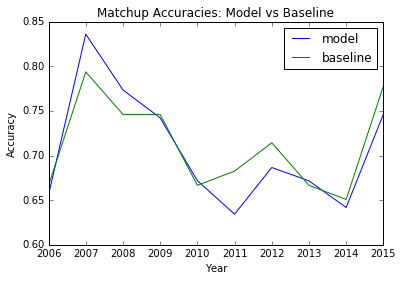

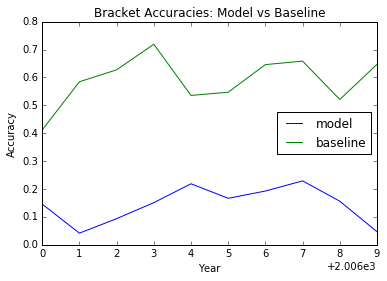

In [15]:
print baselineBracketAccuracies
years_06 = range(2006, 2016, 1)

fig, ax = plt.subplots()

ax.plot(years_06, modelMatchupAccuracies, color='b', label='model')
ax.plot(years_06, baselineMatchupAccuracies, color='g', label='baseline')
plt.xlabel("Year")
plt.ylabel("Accuracy")
plt.title("Matchup Accuracies: Model vs Baseline")
plt.legend(loc='best')
ax.ticklabel_format(useOffset=False)
plt.show()

plt.clf()
plt.plot(years_06, modelBracketAccuracies, color='b', label='model')
plt.plot(years_06, baselineBracketAccuracies, color='g', label='baseline')
plt.xlabel("Year")
plt.ylabel("Accuracy")
plt.title("Bracket Accuracies: Model vs Baseline")
plt.legend(loc='best')
plt.show()

In [9]:
baselineAccuracies = []
bestBracketAccuracies = []

for i in range(2003, 2013):
    marchMadnessModel = MarchMadnessTournament(i+3)
    topBrackets = np.array(marchMadnessModel.topBrackets)
    
    averageBaselineAccuracy = 0.0
    for j in range(10):
        marchMadnessModel = MarchMadnessTournament(i+3)
        averageBaselineAccuracy += marchMadnessModel.baselineBracketAccuracy
    
    averageBaselineAccuracy /= 10.0
    bestBracketAccuracy = topBrackets[-1, 1]
    
    baselineAccuracies.append(averageBaselineAccuracy)
    bestBracketAccuracies.append(bestBracketAccuracy)
    
    #plt.clf
    #plt.plot(range(10), topBrackets[:, 1], color='b', label='Model Accuracy')
    #plt.plot(range(10), [averageBaselineAccuracy]*10, color='g', label='Baseline Accuracy')
    #plt.ylabel("Accuracy")
    #plt.title(str(i+3) + "Bracket Accuracies: Model vs Baseline")
    #plt.legend(loc='best')
    #plt.show()
    #best_bracket_each_year_acc.append(max(topBrackets[:, 1]))
    
print baselineAccuracies
print bestBracketAccuracies

numBetter = 0.0
baselineTop5 = 0.0
baselineTop10 = 0.0
top5Perc = 0.0
top10Perc = 0.0
for i in range(10):
    if baselineAccuracies[i] < bestBracketAccuracies[i]:
        numBetter += 1
    if baselineAccuracies[i] * 1930.0 >= 980:
        baselineTop5 += 1
    if baselineAccuracies[i] * 1930.0 >= 920:
        baselineTop10 += 1
    if bestBracketAccuracies[i] * 1930.0 >= 980:
        top5Perc += 1
    if bestBracketAccuracies[i] * 1930.0 >= 920:
        top10Perc += 1

print "We beat baseline in", numBetter * 10, "percent of years"
print "Baseline model is a top 5% bracket in", baselineTop5 * 10, "percent of years"
print "Baseline model is a top 10% bracket in", baselineTop10 * 10, "percent of years"
print "We got a top 5% bracket in", top5Perc * 10, "percent of years"
print "We got a top 10% bracket in", top10Perc * 10, "percent of years"

[0.41145833333333337, 0.6260416666666667, 0.6604166666666667, 0.71875, 0.4354166666666666, 0.546875, 0.6458333333333333, 0.6583333333333333, 0.5208333333333333, 0.6302083333333335]
[0.5052083333333334, 0.3854166666666667, 0.5, 0.4635416666666667, 0.4739583333333333, 0.4270833333333333, 0.3697916666666667, 0.5677083333333334, 0.6145833333333334, 0.2864583333333333]
We beat baseline in 30.0 percent of years
Baseline model is a top 5% bracket in 80.0 percent of years
Baseline model is a top 10% bracket in 80.0 percent of years
We got a top 5% bracket in 20.0 percent of years
We got a top 10% bracket in 40.0 percent of years


Change above function to change year our model shows. Change below to change year of the models we are automatically creating
My code starts below, should be able to run everything no problem

In [19]:
differential_scores = []

for i in range(2003, 2013):
    marchMadnessModel = MarchMadnessTournament(i+3)
    topBrackets = np.array(marchMadnessModel.topBrackets)
    BaselineDif = topBrackets[-1,2]
    differential_scores.append(BaselineDif)

In [20]:
print differential_scores

[0.8888888888888888, 0.6984126984126984, 0.7777777777777778, 0.7301587301587301, 0.8412698412698413, 0.7936507936507936, 0.8253968253968254, 0.8253968253968254, 0.6031746031746031, 0.873015873015873]


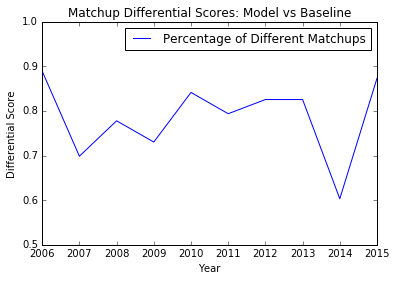

In [25]:
fig, ax = plt.subplots()

ax.plot(years_06, differential_scores, color='b', label='Percentage of Different Matchups')
plt.xlabel("Year")
plt.ylabel("Differential Score")
plt.title("Matchup Differential Scores: Model vs Baseline")
plt.legend(loc='best')
plt.ylim(.5,1)
ax.ticklabel_format(useOffset=False)
plt.show()

In [10]:
#graphing stuff below

In [11]:
def plot_feat(wheader, lheader):
    wfeat = wheader
    wfeat_list = []

    #losing field goals made
    lfeat = lheader
    lfeat_list = []
    years = range(2003, 2016, 1)
    for year in years:
        season_df = pd.read_csv('datasets/toruney_selected_reg_season_detailed_results/reg_season/' + str(year) + '_regular_seas.csv', delimiter = ',')
        wfeat_list.append(season_df[wfeat].mean())
        lfeat_list.append(season_df[lfeat].mean())
        
    plt.plot(years, wfeat_list, color='b', label='Winning Team')
    plt.plot(years, lfeat_list, color='g', label='Losing Team')
    plt.xlabel("Year")
    head_dic = {"Wscore":"Scores", "Wfgm":"Field Goals Made",
               "Wfgm3":"3pters Made", "Wftm":"Free Throws Made",
               "Wor":"Offensive Rebounds", "Wdr":"Deffensive Rebounds",
               "Wast":"Assits", "Wto":"Turn Overs", "Wstl":"Steals",
               "Wblk":"Blocks", "Wpf":"Personal Fouls"}
    plt.ylabel(head_dic[wheader])
    plt.legend(loc='best')
    title = "Average %s, years 2003-2015" %(head_dic[wheader])
    plt.title(title)
    plt.show()
    

In [12]:
w_stats = ["Wscore", "Wfgm", "Wfgm3", "Wftm","Wor",
            "Wdr","Wast", "Wto", "Wstl","Wblk", "Wpf"]
l_stats = ["Lscore", "Lfgm", "Lfgm3", "Lftm","Lor",
            "Ldr","Last", "Lto", "Lstl","Lblk", "Lpf"]

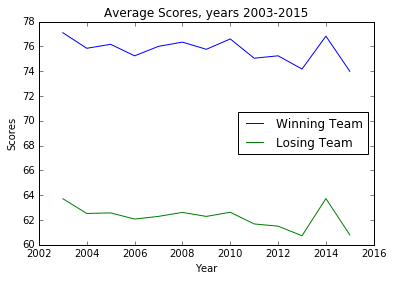

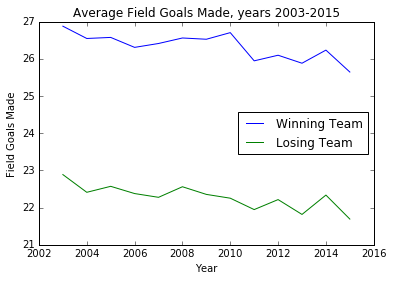

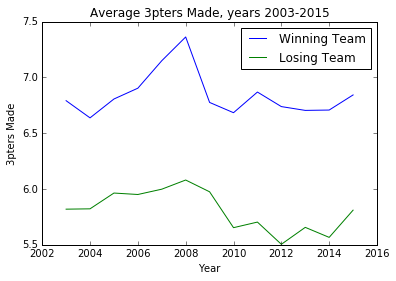

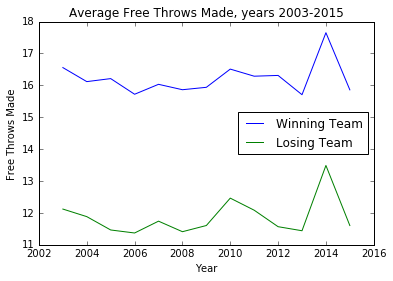

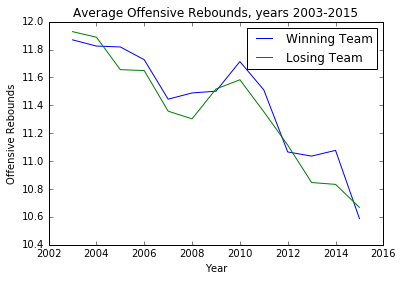

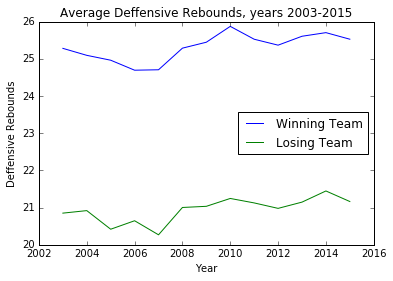

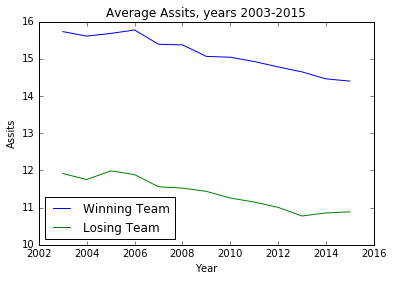

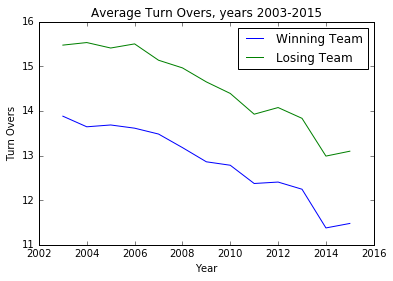

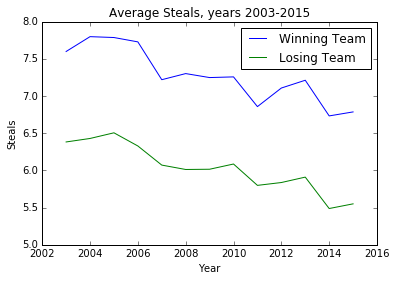

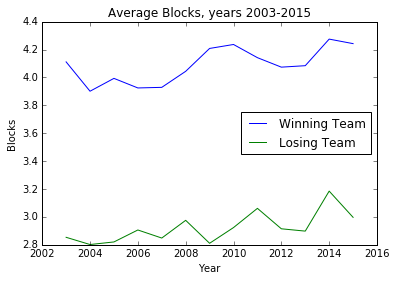

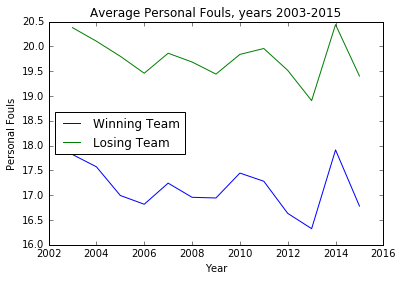

In [13]:
for index, stat in enumerate(w_stats):
    plot_feat(stat, l_stats[index])

In [14]:
marchMadnessModel = MarchMadnessTournament(2005)
matchups = marchMadnessModel.matchups
actualBracket = marchMadnessModel.actualBracket
baselineBracket = marchMadnessModel.baselineBracket
baselineBracketAccuracy = marchMadnessModel.baselineBracketAccuracy
print baselineBracketAccuracy

0.6875


In [31]:
finalRankings = bracket_create(2007, logreg)
finalRankings = np.array(finalRankings)
# print finalRankings
# print finalRankings[:, -2]
plt.plot(range(20), finalRankings[:, -2], color='b', label='Accuracy')
plt.plot(range(20), finalRankings[:, -1], color='r', label='Variance')
plt.show()

NameError: name 'bracket_create' is not defined

In [32]:
#scores is a list of tuples, the first of each tuple is the accuracy score, second is the similarity score
scores = []
for brack in ran_brack:
    acc = brack[-2]
    sim = brack[-1]
    scores.append((acc, sim))

NameError: name 'ran_brack' is not defined

In [ ]:
print scores
#just add our model and sort these when you enter
#THIS IS ONLY YEAR 2007
#them in the graph, sort by accuracy scores and we can see how similarity socres change
#acrually looks like they are already sorted
#SIMILARTIY IS HOW CLOSE THEY ARE TO THE BASELINE BRACKET IN TERMS OF SIMILAR GAMES PREDICTED
print glb_mod

In [ ]:
#shared games of our random brackets to baseline seeded model
#have to add our model shared games
shr_game = []
for sc in scores:
    shr_game.append(63.0 - 63.0*sc[-1])

In [ ]:
print shr_game
print 63.0 - 63.0*glb_mod[-1]

In [ ]:
#USE THIS TO MAP OUT CHANGES ACROSS THE YEARLY DATASET
#TAKES THE AVERAGES OF EACH YEAR AND ADS THEM TO THE LIST
#winning field goals made
wfeat_1 = 'Wfgm'
wfeat_1_list = []
#wining blocks
wfeat_2 = 'Wblk'
wfeat_2_list = []
#winning assits
wfeat_3 = 'Wast'
wfeat_3_list = []

#losing field goals made
lfeat_1 = 'Lfgm'
lfeat_1_list = []
#losing blocks
lfeat_2 = 'Lblk'
lfeat_2_list = []
#losing assits
lfeat_3 = 'Last'
lfeat_3_list = []
for year in range (2003, 2016, 1):
    season_df = pd.read_csv('datasets/toruney_selected_reg_season_detailed_results/reg_season/' + str(year) + '_regular_seas.csv', delimiter = ',')
    wfeat_1_list.append(season_df[wfeat_1].mean())
    wfeat_2_list.append(season_df[wfeat_2].mean())
    wfeat_3_list.append(season_df[wfeat_3].mean())
    
    lfeat_1_list.append(season_df[lfeat_1].mean())
    lfeat_2_list.append(season_df[lfeat_2].mean())
    lfeat_3_list.append(season_df[lfeat_3].mean())

In [ ]:
seeds_06 = tourney_seeds_df[tourney_seeds_df.Season == 2006]
team2seed_dic = {}
for index, row in seeds_06.iterrows():
    try:
        team2seed_dic[int(row['Team'])] = int(row['Seed'][1:])
    except:
        team2seed_dic[int(row['Team'])] = int(row['Seed'][1:-1])

In [ ]:
print team2seed_dic

In [ ]:
right = 0.0
tot = 0.0
for index, row in tourney_2006.iterrows():
    if team2seed_dic[row['Wteam']] < team2seed_dic[row['Lteam']]:
        right += 1
    tot += 1
print right/tot

**Map out a graph featuring the two accuracies with different models (like AIC/BIC, or comparing both R^2 - line graph):**

In [ ]:
import math

years = [2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016]

fgWinningAverages = []
fgLosingAverages = []
for year in years:
    cut_year = seasons_results_detailed_df[seasons_results_detailed_df['Season'] == year]

    win_fg = cut_year['Wfgm']
    win_figa = cut_year['Wfga']

    los_fg = cut_year['Lfgm']
    los_figa = cut_year['Lfga']
    
    winPerc = win_fg.div(win_figa)
    losPerc = los_fg.div(los_figa)
    
    fgWinningAverages.append(winPerc.mean())
    fgLosingAverages.append(losPerc.mean())

plt.plot(years, fgWinningAverages, color='b', label='Winning Team')
plt.plot(years, fgLosingAverages, color='g', label='Losing Team')
plt.xlabel("Year")
plt.ylabel("Average FG%")
plt.legend(loc='best')
plt.title("Average FG% Over Time")
plt.show()